In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

import kagglehub

import warnings
warnings.filterwarnings("ignore")

/home/echerif/miniconda3/envs/ironhack/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler


random_state = 5

In [3]:
### Visualization settings ##

##### Matplotlib ##
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'


#### Pandas ###
#### show the max of columns in a pandas object
pd.set_option('display.max_columns', None)

############ Seaborn ##
# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

In [4]:
### Function for Regression evaluation
def Reg_eval(X_train, y_train, MEDV_linReg):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    ### Make predictions
    y_pred_train = MEDV_linReg.predict(X_train)

    r2_score = float(round(r2_score(y_train, y_pred_train),3))
    RMSE = float(round(np.sqrt(mean_squared_error(y_pred_train, y_train)),3))
    MAE = float(round(mean_absolute_error(y_pred_train, y_train),3))

    reg_scores = pd.DataFrame([r2_score, RMSE, MAE], index=['r2_score', 'RMSE', 'MAE'])
    return reg_scores.T

# 1. Load the dataset

In [5]:
full_path = "data/df_fe.csv"
king_hs = pd.read_csv(full_path)

- This version of the cleaned dataset

In [6]:
display(king_hs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21606 entries, 0 to 21605
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      21606 non-null  int64  
 1   date                    21606 non-null  object 
 2   price                   21606 non-null  float64
 3   bedrooms                21606 non-null  int64  
 4   bathrooms               21606 non-null  float64
 5   sqft_living             21606 non-null  float64
 6   sqft_lot                21606 non-null  float64
 7   floors                  21606 non-null  float64
 8   waterfront              21606 non-null  int64  
 9   view                    21606 non-null  int64  
 10  condition               21606 non-null  int64  
 11  grade                   21606 non-null  int64  
 12  sqft_above              21606 non-null  int64  
 13  sqft_basement           21606 non-null  int64  
 14  yr_built                21606 non-null

None

In [7]:
for i in king_hs.columns:
    print(f'{i}: {king_hs[i].nunique()}')

id: 21429
date: 372
price: 3889
bedrooms: 13
bathrooms: 30
sqft_living: 887
sqft_lot: 9615
floors: 6
waterfront: 2
view: 5
condition: 5
grade: 11
sqft_above: 943
sqft_basement: 306
yr_built: 116
yr_renovated: 70
zipcode: 70
lat: 5033
long: 752
sqft_living15: 684
sqft_lot15: 8544
log_price: 4025
year_sold: 2
month_sold: 12
house_age: 117
renovated: 2
years_since_renovation: 71
sqft_per_bedroom: 1551
sold_occ: 3
loc_clusters: 4
grade_clean: 7


In [8]:
# Fix the 33-bedroom outlier (likely a typo for 3)
king_hs.loc[king_hs['bedrooms'] == 33, 'bedrooms'] = 3

# 2. Split the dataset into features (X) and target (y).

In [9]:
king_hs_X = king_hs.drop(['price','log_price'], axis=1)
king_hs_y = king_hs[['price']]

In [10]:
king_hs_X_clean = king_hs_X.copy()

In [11]:
king_hs_X.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'house_age',
       'renovated', 'years_since_renovation', 'sqft_per_bedroom', 'sold_occ',
       'loc_clusters', 'grade_clean'],
      dtype='object')

# 3. Train baseline models: Linear Regression and Evaluate the models using metrics like R², RMSE and MAE.

In [12]:
#### Baseline after cleaning the data: Outliers and removed erroneous rows
# - Improve the baseline:
#     - check the data with 0 bedrooms and 0 bathrooms
#     - OUTLIERS

In [13]:
def baseline_train(king_hs_X_clean, king_hs_y):
    X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean, king_hs_y, random_state=random_state, test_size=0.2)

    ### Prepare the baseline 
    lin_baseline = LinearRegression()
    lin_baseline.fit(X_train, y_train)

    eval_tr = Reg_eval(X_train, y_train, lin_baseline)
    eval_ts = Reg_eval(X_test, y_test, lin_baseline)

    eval = pd.concat([eval_tr,eval_ts])
    eval.index=['train', 'test']
    return eval

In [14]:
def baseline_cv(king_hs_X_clean, king_hs_y):
    from sklearn.model_selection import cross_validate

    ### Prepare the baseline 
    lin_baseline = LinearRegression()

    cv_results = cross_validate(lin_baseline, king_hs_X_clean, king_hs_y, cv=3, scoring=('r2', 'neg_mean_squared_error',  'neg_mean_absolute_error'))

    return cv_results

In [15]:
baseline_columns = ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view',
        'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold']

In [16]:
baseline_train(king_hs_X_clean[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.738,162453.101,113154.318
test,0.743,161368.913,112806.907


In [17]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01870942, 0.01617455, 0.01645255]),
 'score_time': array([0.00595498, 0.00569367, 0.00599194]),
 'test_r2': array([0.74266012, 0.73274476, 0.72659796]),
 'test_neg_mean_squared_error': array([-2.95489167e+10, -2.76876102e+10, -2.30126442e+10]),
 'test_neg_mean_absolute_error': array([-117950.95060602, -114960.21778687, -108821.45408904])}

# 4. Improve the baseline:


## Data side

- Test feature engineering on the baseline:
    - change yr_renovated (binary)
    - yr_built >> convert to age based on reference year (e.g. 1900)
    - replace long, lat and zipcode >> with k-means clusters
    - transform the grade to a better grade system (12 grades here)
    - replace the year with a flag column >> sold_occ

### sqft_above

In [18]:
king_hs_X_clean_im = king_hs_X_clean.copy()

king_hs_X_clean_im.drop(['sqft_above'], axis=1, inplace=True)

In [19]:
baseline_columns = [
  'id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
#  'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold']

In [20]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.737,162962.310,113722.988
test,0.740,162482.062,113730.605


In [21]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01563287, 0.01713514, 0.01573849]),
 'score_time': array([0.00661683, 0.00591707, 0.00598288]),
 'test_r2': array([0.74056663, 0.73055855, 0.72582083]),
 'test_neg_mean_squared_error': array([-2.97893006e+10, -2.79141014e+10, -2.30780564e+10]),
 'test_neg_mean_absolute_error': array([-118664.94207482, -115586.26383876, -109510.54560565])}

- sqft_above: slight drop in the perfomance

### zipcode

In [22]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [23]:
baseline_columns = [
  'id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold',
 
 'loc_clusters',
 #  'zipcode'
 ]

In [24]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.748,159323.483,108877.036
test,0.754,158047.484,108494.530


In [25]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01797152, 0.0193584 , 0.02040863]),
 'score_time': array([0.00771999, 0.00763822, 0.00792766]),
 'test_r2': array([0.75174143, 0.74310856, 0.74011913]),
 'test_neg_mean_squared_error': array([-2.85061604e+10, -2.66139214e+10, -2.18745481e+10]),
 'test_neg_mean_absolute_error': array([-113466.04456542, -110459.07065686, -104219.13138181])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 

### grade_clean

In [26]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [27]:
baseline_columns = [
  'id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
#  'grade',
 'grade_clean',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold',
 'zipcode',
#  'loc_clusters'
 ]

In [28]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.740,161940.787,113606.018
test,0.742,161789.679,113543.527


In [29]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01994157, 0.01771641, 0.0192008 ]),
 'score_time': array([0.00917864, 0.00852656, 0.00635052]),
 'test_r2': array([0.74455956, 0.73440014, 0.72639769]),
 'test_neg_mean_squared_error': array([-2.93308148e+10, -2.75161130e+10, -2.30295007e+10]),
 'test_neg_mean_absolute_error': array([-118179.91685821, -115611.34302529, -109365.08140745])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 
- grade_clean: Slight drop
- grade_clean:**Slight improvement**

###  sold_occ

In [30]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [31]:
baseline_columns = [
  # 'id',
'sold_occ',

 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold',
 
 'zipcode',
#  'loc_clusters'
 ]

In [32]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.738,162469.163,113093.665
test,0.744,161233.529,112727.323


In [33]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.0180192 , 0.01712537, 0.01746368]),
 'score_time': array([0.00725985, 0.00725102, 0.00714588]),
 'test_r2': array([0.74187811, 0.73310377, 0.72668657]),
 'test_neg_mean_squared_error': array([-2.96387108e+10, -2.76504165e+10, -2.30051859e+10]),
 'test_neg_mean_absolute_error': array([-117858.66761534, -114823.71457101, -109025.82897439])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 
- grade_clean: Slight drop
- grade_clean:**Slight improvement**
- sold_occ **Slight improvement**

### age drop yr_renovated

In [34]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [35]:
baseline_columns = [
  'id',
# 'sold_occ',

 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade_clean',
 'sqft_above',
 'sqft_basement',

 'yr_built',
 'yr_renovated',
#  'house_age',

 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold',

 'lat',
 'long',
 'zipcode',
#  'loc_clusters'
 ]

In [36]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.740,161940.787,113606.018
test,0.742,161789.679,113543.527


In [37]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01784086, 0.01805997, 0.01730537]),
 'score_time': array([0.00702119, 0.00594497, 0.0058949 ]),
 'test_r2': array([0.74455956, 0.73440014, 0.72639769]),
 'test_neg_mean_squared_error': array([-2.93308148e+10, -2.75161130e+10, -2.30295007e+10]),
 'test_neg_mean_absolute_error': array([-118179.91685822, -115611.34302529, -109365.08140746])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 
- grade_clean: Slight drop
- grade_clean:**Slight improvement**
- sold_occ **Slight improvement**
- Age: Drop in the perfoemance

### drop month_sold

In [38]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [39]:
baseline_columns = [
  'id',
# 'sold_occ',

 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade_clean',
 'sqft_above',
 'sqft_basement',

 'yr_built',
 'yr_renovated',
# 'renovated',
#  'house_age',

 'sqft_living15',
 'sqft_lot15',
 'year_sold',
#  'month_sold',

 'lat',
 'long',
 'zipcode',
#  'loc_clusters'
 ]

In [40]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.740,161946.138,113600.625
test,0.742,161800.948,113568.074


In [41]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.0188241 , 0.01935625, 0.02067184]),
 'score_time': array([0.00856614, 0.00598192, 0.00649142]),
 'test_r2': array([0.74458101, 0.73436559, 0.72639433]),
 'test_neg_mean_squared_error': array([-2.93283519e+10, -2.75196923e+10, -2.30297842e+10]),
 'test_neg_mean_absolute_error': array([-118163.56622889, -115622.88987805, -109347.76430819])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 
- grade_clean: Slight drop
- grade_clean:**Slight improvement**
- sold_occ **Slight improvement**
- Age: Drop in the perfoemance
- month_sold: drop in perfoemance

### year_sold

In [42]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [43]:
baseline_columns = [
  'id',
# 'sold_occ',

 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade_clean',
 'sqft_above',
 'sqft_basement',

 'yr_built',
 'yr_renovated',
# 'renovated',
#  'house_age',

 'sqft_living15',
 'sqft_lot15',
#  'year_sold',
#  'month_sold',

 'lat',
 'long',
 'zipcode',
#  'loc_clusters'
 ]

In [44]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.738,162472.718,114047.185
test,0.739,162537.659,114256.884


In [45]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01573658, 0.01821685, 0.01592708]),
 'score_time': array([0.00862384, 0.00769639, 0.00730085]),
 'test_r2': array([0.74304038, 0.73300799, 0.72339592]),
 'test_neg_mean_squared_error': array([-2.95052538e+10, -2.76603401e+10, -2.32821648e+10]),
 'test_neg_mean_absolute_error': array([-118750.93696457, -116083.76096177, -109796.02204454])}

- sqft_above: slight drop in the perfomance
- zipcode: Jump **Imporoved  the perfomance** 
- grade_clean: Slight drop
- grade_clean:**Slight improvement**
- sold_occ **Slight improvement**
- Age: Drop in the perfoemance
- month_sold: drop in perfoemance
- year_sold: drop in perfoamance

### yr_renovated

In [46]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [47]:
baseline_columns = [
  'id',
# 'sold_occ',

 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade_clean',
 'sqft_above',
 'sqft_basement',

 'yr_built',
#  'yr_renovated',
'renovated',
#  'house_age',

 'sqft_living15',
 'sqft_lot15',
 'year_sold',
 'month_sold',

 'lat',
 'long',
#  'zipcode',
 'loc_clusters'
 ]

In [48]:
baseline_train(king_hs_X_clean_im[baseline_columns], king_hs_y)

,r2_score,RMSE,MAE
train,0.751,158429.864,108389.025
test,0.754,157995.931,107975.661


In [49]:
baseline_cv(king_hs_X_clean[baseline_columns], king_hs_y)

{'fit_time': array([0.01873302, 0.02067494, 0.01919556]),
 'score_time': array([0.00598431, 0.00632811, 0.00626135]),
 'test_r2': array([0.75393078, 0.74649638, 0.74186522]),
 'test_neg_mean_squared_error': array([-2.82547691e+10, -2.62629440e+10, -2.17275769e+10]),
 'test_neg_mean_absolute_error': array([-113606.02199375, -109688.01205396, -103464.29592907])}

- No effect

### Conclusions

From the baseline:
- The drop of (0 bedrooms 0 bathroom ): jump in the perfoemance

- Feature engineering
    - drop sqft_above: slight drop in the perfomance
    - replace with clustes: zipcode: Jump **Imporoved  the perfomance** 
    - change categories: grade_clean: Slight drop
    - flag instead of id sold_occ **Slight improvement**
    - replace build and renovated year Age: Drop in the perfoemance
    - drop month_sold: drop in perfoemance
    - drop year_sold: drop in perfoamance
    - no effect yr_renovated no effect to bool

### Best LinearRegression after feature engineering

In [50]:
#### Dropped features
# 'id', 'date', 'house_age', 'years_since_renovation', 'sqft_per_bedroom', 'zipcode', 'sqft_per_bedroom', 'grade_clean','yr_renovated', '

In [51]:
best_features= [
 'bedrooms',
 'bathrooms',

 'sqft_living',
 'sqft_lot',

 'floors',
 'waterfront',
 'view',
 'condition',

 'grade',
 'sqft_above',
 'sqft_basement',

 'yr_built',
 'renovated',

 'sqft_living15',
 'sqft_lot15',

 'year_sold',
 'month_sold',

  'lat',
 'long',
 'loc_clusters',  
 'sold_occ'
 ]

In [52]:
king_hs_X_clean_im = king_hs_X_clean.copy()

In [53]:
baseline_train(king_hs_X_clean_im[best_features], king_hs_y)

,r2_score,RMSE,MAE
train,0.748,159366.572,108806.532
test,0.754,157915.963,108415.630


In [54]:
baseline_cv(king_hs_X_clean[best_features], king_hs_y)

{'fit_time': array([0.02037716, 0.01915598, 0.02081728]),
 'score_time': array([0.0082643 , 0.00727558, 0.0106616 ]),
 'test_r2': array([0.75072294, 0.74348497, 0.73964885]),
 'test_neg_mean_squared_error': array([-2.86231077e+10, -2.65749260e+10, -2.19141318e+10]),
 'test_neg_mean_absolute_error': array([-113310.70078618, -110253.95850922, -104664.68540961])}

### Feature importance

In [55]:
X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean[best_features], king_hs_y, random_state=random_state, test_size=0.2, shuffle=True)

### Prepare the baseline 
lin_improve = LinearRegression()
lin_improve.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [56]:
selector = RFE(lin_improve, n_features_to_select=10, step=1) ##xgb_reg, lin_baseline
selector = selector.fit(X_train, y_train)

In [57]:
# Get feature names and rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
}).sort_values('Ranking')

print("Features ordered by importance:")
print(feature_ranking)

# Just the top 5 selected features
print("\nTop 5 Selected Features:")
print(feature_ranking[feature_ranking['Selected'] == True]['Feature'].tolist())

Features ordered by importance:
          Feature  Ranking  Selected
1       bathrooms        1      True
7       condition        1      True
6            view        1      True
5      waterfront        1      True
12      renovated        1      True
8           grade        1      True
18           long        1      True
17            lat        1      True
20       sold_occ        1      True
19   loc_clusters        1      True
15      year_sold        2     False
0        bedrooms        3     False
4          floors        4     False
11       yr_built        5     False
16     month_sold        6     False
9      sqft_above        7     False
10  sqft_basement        8     False
13  sqft_living15        9     False
2     sqft_living       10     False
14     sqft_lot15       11     False
3        sqft_lot       12     False

Top 5 Selected Features:
['bathrooms', 'condition', 'view', 'waterfront', 'renovated', 'grade', 'long', 'lat', 'sold_occ', 'loc_clusters']


## Model side: XGBOOST with hyperparameter tuning.

### XgBoost

In [58]:
def xgb_train(king_hs_X_clean, king_hs_y):
    import xgboost as xgb

    X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean, king_hs_y, random_state=random_state, test_size=0.2)

    ### Prepare the baseline 
    xgb = xgb.XGBRegressor()
    xgb.fit(X_train, y_train)

    eval_tr = Reg_eval(X_train, y_train, xgb)
    eval_ts = Reg_eval(X_test, y_test, xgb)

    eval = pd.concat([eval_tr,eval_ts])
    eval.index=['train', 'test']
    return eval

def xgb_cv(king_hs_X_clean, king_hs_y):
    from sklearn.model_selection import cross_validate
    import xgboost as xgb

    ### Prepare the baseline 
    xgb = xgb.XGBRegressor()

    cv_results = cross_validate(xgb, king_hs_X_clean, king_hs_y, cv=3, scoring=('r2', 'neg_mean_squared_error',  'neg_mean_absolute_error'))

    return cv_results

In [59]:
xgb_train(king_hs_X_clean[best_features], king_hs_y)

,r2_score,RMSE,MAE
train,0.971,53874.865,38387.367
test,0.912,94508.141,61144.875


In [60]:
xgb_cv(king_hs_X_clean[best_features], king_hs_y)

{'fit_time': array([ 1.1230545 , -1.69157195,  1.26300406]),
 'score_time': array([0.01813388, 0.01980925, 0.01880407]),
 'test_r2': array([0.884942  , 0.88263726, 0.88811511]),
 'test_neg_mean_squared_error': array([-1.32114780e+10, -1.21587681e+10, -9.41751194e+09]),
 'test_neg_mean_absolute_error': array([-70885.53125  , -69179.1640625, -63802.2421875])}

#### Fine-tuning

In [61]:
## use GridSearchCV search
X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean[best_features], king_hs_y, random_state=random_state, test_size=0.2)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create GridSearchCV
grid_search = GridSearchCV( ##RandomizedSearchCV , GridSearchCV
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; tota

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation ti

In [62]:
# Best parameters and score
print("\n" + "="*70)
print("BEST PARAMETERS:")
print("="*70)
print(grid_search.best_params_)

print("\n" + "="*70)
print("BEST SCORE (CV):")
print("="*70)
print(f"Best CV Score: {-grid_search.best_score_:.4f}")  # Negative because of neg_mse


BEST PARAMETERS:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

BEST SCORE (CV):
Best CV Score: 9448263884.8000


In [ ]:
# Get the best model
best_xgb = grid_search.best_estimator_

### On train set
y_pred_tr = best_xgb.predict(X_train)
eval_tr = pd.DataFrame([r2_score(y_train, y_pred_tr), np.sqrt(mean_squared_error(y_train, y_pred_tr)), mean_absolute_error(y_train, y_pred_tr)], index=['r2_score', 'RMSE', 'MAE']).T

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
eval_ts = pd.DataFrame([r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)], index=['r2_score', 'RMSE', 'MAE']).T

eval = pd.concat([eval_tr,eval_ts])
eval.index=['train', 'test']
eval

,r2_score,RMSE,MAE
train,0.985048,38825.41683,28170.755859
test,0.916756,91873.29292,58558.921875


### With scaler

In [64]:
## With  scaling
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean[best_features], king_hs_y, random_state=random_state, test_size=0.2)

# Start fresh - standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300], #400, 500, 600
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create GridSearchCV
grid_search = GridSearchCV( ##RandomizedSearchCV , GridSearchCV
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train_scaled, y_train)

Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; tota

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation ti

In [65]:
# Best parameters and score
print("\n" + "="*70)
print("BEST PARAMETERS:")
print("="*70)
print(grid_search.best_params_)

print("\n" + "="*70)
print("BEST SCORE (CV):")
print("="*70)
print(f"Best CV Score: {-grid_search.best_score_:.4f}")  # Negative because of neg_mse

# Get the best model
best_xgb = grid_search.best_estimator_

### On train set
y_pred_tr = best_xgb.predict(X_train_scaled)
eval_tr = pd.DataFrame([r2_score(y_train, y_pred_tr), np.sqrt(mean_squared_error(y_train, y_pred_tr)), mean_absolute_error(y_train, y_pred_tr)], index=['r2_score', 'RMSE', 'MAE']).T

# Evaluate on test set
y_pred = best_xgb.predict(X_test_scaled)
eval_ts = pd.DataFrame([r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)], index=['r2_score', 'RMSE', 'MAE']).T

eval = pd.concat([eval_tr,eval_ts])
eval.index=['train', 'test']
eval


BEST PARAMETERS:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

BEST SCORE (CV):
Best CV Score: 9448263884.8000


,r2_score,RMSE,MAE
train,0.985048,38825.41683,28170.755859
test,0.916756,91873.29292,58558.921875


- No effect with scaler

### Feature importance

In [66]:
# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [67]:
selector = RFE(best_xgb, n_features_to_select=10, step=1) ##xgb_reg, lin_baseline
selector = selector.fit(X_train, y_train)

# Get feature names and rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
}).sort_values('Ranking')

print("Features ordered by importance:")
print(feature_ranking)

# Just the top 5 selected features
print("\nTop 5 Selected Features:")
print(feature_ranking[feature_ranking['Selected'] == True]['Feature'].tolist())

Features ordered by importance:
          Feature  Ranking  Selected
2     sqft_living        1      True
5      waterfront        1      True
6            view        1      True
8           grade        1      True
13  sqft_living15        1      True
11       yr_built        1      True
9      sqft_above        1      True
17            lat        1      True
18           long        1      True
19   loc_clusters        1      True
12      renovated        2     False
7       condition        3     False
14     sqft_lot15        4     False
15      year_sold        5     False
3        sqft_lot        6     False
4          floors        7     False
1       bathrooms        8     False
10  sqft_basement        9     False
20       sold_occ       10     False
16     month_sold       11     False
0        bedrooms       12     False

Top 5 Selected Features:
['sqft_living', 'waterfront', 'view', 'grade', 'sqft_living15', 'yr_built', 'sqft_above', 'lat', 'long', 'loc_clusters']


### Test with Top features

In [68]:
top_features = feature_ranking[feature_ranking['Selected'] == True]['Feature'].tolist()
rest_rf = feature_ranking[feature_ranking['Selected'] == False]['Feature'].tolist()

In [69]:
## use gardient search
X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean[top_features], king_hs_y, random_state=random_state, test_size=0.2)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create GridSearchCV
grid_search = GridSearchCV( ##RandomizedSearchCV , GridSearchCV
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; tota

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation ti

In [ ]:
# Get the best model
best_xgb = grid_search.best_estimator_

### On train set
y_pred_tr = best_xgb.predict(X_train)
eval_tr = pd.DataFrame([r2_score(y_train, y_pred_tr), np.sqrt(mean_squared_error(y_train, y_pred_tr)), mean_absolute_error(y_train, y_pred_tr)], index=['r2_score', 'RMSE', 'MAE']).T

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
eval_ts = pd.DataFrame([r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)], index=['r2_score', 'RMSE', 'MAE']).T

eval = pd.concat([eval_tr,eval_ts])
eval.index=['train', 'test']
eval


,r2_score,RMSE,MAE
train,0.974040,51158.568236,36277.750000
test,0.905079,98105.711475,63687.796875


- Drop in the model when using only top 10 features

#### PLS to learn linear features for the rest 5 features >> compress into two features

In [71]:
### PLS
X_train, X_test, y_train, y_test = train_test_split(king_hs_X_clean[best_features], king_hs_y, random_state=random_state, test_size=0.2)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [72]:
# PLS FOR FEATURE ENGINEERING:
n_components = 2
pls = PLSRegression(n_components=n_components, scale=False)

print(f"\nFitting PLS with {n_components} components...")
print("PLS is learning components that are correlated with price (Y)")
pls.fit(X_train[rest_rf], y_train)

# Step 3: Transform X to get new features (PLS components)
X_train_pls = pls.transform(X_train[rest_rf])
X_test_pls = pls.transform(X_test[rest_rf])

print(f"\nCreated {n_components} new PLS features!")
print("These features are engineered to predict price well")


Fitting PLS with 2 components...
PLS is learning components that are correlated with price (Y)

Created 2 new PLS features!
These features are engineered to predict price well


In [73]:
# X_train_top_pls = pd.concat([X_train[top_features].reset_index(drop=True), pd.DataFrame(X_train_pls)], axis=1)
# X_train_top_pls = pd.concat([X_test[top_features].reset_index(drop=True), pd.DataFrame(X_test_pls)], axis=1)

In [74]:
# USING PLS COMPONENTS AS FEATURES

# with XGBoost
xgb = XGBRegressor(n_estimators=300, random_state=42, verbosity=0, colsample_bytree= 0.8, learning_rate= 0.1, max_depth = 7, subsample=1.0)
xgb.fit(pd.concat([X_train[top_features].reset_index(drop=True), pd.DataFrame(X_train_pls)], axis=1), y_train)
y_pred_xgb = xgb.predict(pd.concat([X_test[top_features].reset_index(drop=True), pd.DataFrame(X_test_pls)], axis=1))

print("\nXGBoost on PLS components:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):,.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):,.2f}")
print(f"  R²: {r2_score(y_test, y_pred_xgb):.4f}")


XGBoost on PLS components:
  RMSE: 95,091.97
MAE: 62,238.78
  R²: 0.9108


In [75]:
y_pred_xgb_tr = xgb.predict(pd.concat([X_train[top_features].reset_index(drop=True), pd.DataFrame(X_train_pls)], axis=1))

eval_tr = pd.DataFrame([r2_score(y_train, y_pred_xgb_tr), np.sqrt(mean_squared_error(y_train, y_pred_xgb_tr)), mean_absolute_error(y_train, y_pred_xgb_tr)], index=['r2_score', 'RMSE', 'MAE']).T

y_pred_xgb = xgb.predict(pd.concat([X_test[top_features].reset_index(drop=True), pd.DataFrame(X_test_pls)], axis=1))
eval_ts = pd.DataFrame([r2_score(y_test, y_pred_xgb), np.sqrt(mean_squared_error(y_test, y_pred_xgb)), mean_absolute_error(y_test, y_pred_xgb)], index=['r2_score', 'RMSE', 'MAE']).T

eval = pd.concat([eval_tr,eval_ts])
eval.index=['train', 'test']
eval

,r2_score,RMSE,MAE
train,0.979675,45267.001668,32196.177734
test,0.910821,95091.972322,62238.777344


## Xgboost with new feature engeineering and scaled y

In [76]:
from sklearn.cluster import KMeans

# 1. LOAD AND CLEAN
full_path = "data/df_fe.csv"
king_hs = pd.read_csv(full_path)


# Fix the 33-bedroom outlier (likely a typo for 3)
king_hs.loc[king_hs['bedrooms'] == 33, 'bedrooms'] = 3

# 2. SEATTLE DISTANCE (The 'Location' Gamechanger)
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371 # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * r * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Downtown Seattle coords
seattle_lat, seattle_long = 47.6062, -122.3321
king_hs['dist_seattle'] = haversine_distance(king_hs['lat'], king_hs['long'], seattle_lat, seattle_long)

# 3. REGENERATE CLUSTERS
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(king_hs[['long', 'lat']])
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
king_hs['loc_clusters'] = kmeans.fit_predict(coords_scaled)

# 4. FEATURE ENGINEERING (Ratios and Interactions)
king_hs['log_price'] = np.log1p(king_hs['price'])
king_hs['total_living_ratio'] = king_hs['sqft_living'] / (king_hs['sqft_lot'] + 1)
king_hs['relative_size'] = king_hs['sqft_living'] / (king_hs['sqft_living15'] + 1)
king_hs['luxury_index'] = king_hs['grade'] + king_hs['view'] + (king_hs['waterfront'] * 2)
king_hs['quality_interaction'] = king_hs['grade'] * king_hs['condition']
king_hs['size_grade_interaction'] = king_hs['sqft_living'] * king_hs['grade']

# 5. DEFINE FEATURES
best_features = [
'bathrooms', 
'sqft_living', 
'sqft_lot', 
'sqft_above', 
'sqft_basement',
'lat', 'long', 'sqft_living15', 'sqft_lot15', "waterfront", "view", "condition", "grade",

'dist_seattle', 'total_living_ratio', 'relative_size',
 'luxury_index', 'quality_interaction', 'size_grade_interaction',
  "year_sold", 'house_age', "zipcode", 'loc_clusters'
]


In [77]:
king_hs_X = king_hs.drop(['price','log_price'], axis=1)
king_hs_y = king_hs[['log_price']]

In [78]:
## use grid search
X_train, X_test, y_train, y_test = train_test_split(king_hs_X[best_features], king_hs_y, random_state=random_state, test_size=0.2)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create GridSearchCV
grid_search = GridSearchCV( ##RandomizedSearchCV , GridSearchCV
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation ti

In [79]:
# Best parameters and score
print("\n" + "="*70)
print("BEST PARAMETERS:")
print("="*70)
print(grid_search.best_params_)

print("\n" + "="*70)
print("BEST SCORE (CV):")
print("="*70)
print(f"Best CV Score: {-grid_search.best_score_:.4f}")  # Negative because of neg_mse


BEST PARAMETERS:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

BEST SCORE (CV):
Best CV Score: 0.0260


In [80]:
# Get the best model
#np.expm1
best_xgb = grid_search.best_estimator_

### On train set
y_pred_tr = np.expm1(best_xgb.predict(X_train))
y_train_recaled =  np.expm1(y_train)
eval_tr = pd.DataFrame([r2_score(y_train_recaled, y_pred_tr), np.sqrt(mean_squared_error(y_train_recaled, y_pred_tr)), mean_absolute_error(y_train_recaled, y_pred_tr)], index=['r2_score', 'RMSE', 'MAE']).T

# Evaluate on test set
y_pred = np.expm1(best_xgb.predict(X_test))
y_test_recaled =  np.expm1(y_test)
eval_ts = pd.DataFrame([r2_score(y_test_recaled, y_pred), np.sqrt(mean_squared_error(y_test_recaled, y_pred)), mean_absolute_error(y_test_recaled, y_pred)], index=['r2_score', 'RMSE', 'MAE']).T

eval = pd.concat([eval_tr,eval_ts])
eval.index=['train', 'test']
eval

,r2_score,RMSE,MAE
train,0.951974,69583.251318,45304.148438
test,0.916086,92242.177251,58919.042969


Feature Importance:
                   Feature  Importance
16            luxury_index    0.271476
18  size_grade_interaction    0.221254
12                   grade    0.201556
5                      lat    0.109582
1              sqft_living    0.042737
13            dist_seattle    0.024395
9               waterfront    0.022893
17     quality_interaction    0.019488
7            sqft_living15    0.013857
6                     long    0.008729
21                 zipcode    0.007990
19               year_sold    0.007749
3               sqft_above    0.007538
22            loc_clusters    0.005872
20               house_age    0.005584
2                 sqft_lot    0.005029
8               sqft_lot15    0.004868
10                    view    0.004805
14      total_living_ratio    0.004294
11               condition    0.003989
0                bathrooms    0.002583
15           relative_size    0.001911
4            sqft_basement    0.001821


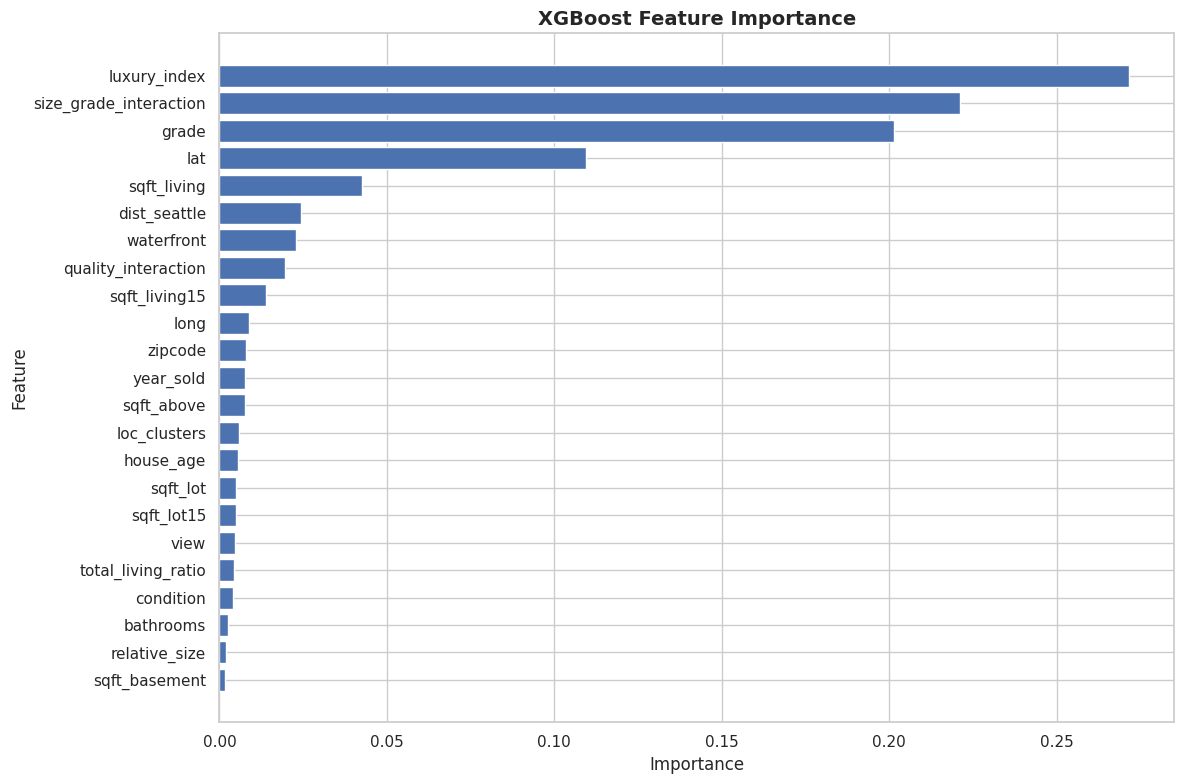

In [81]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

# Display
print("Feature Importance:")
print(feature_importance)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()